# MLVOT: Pratical Work 2

**Objective**: Develop a simple IoU-based tracker without using image information. Extend the algorithm to
handle multiple object tracking simultaneously.

In [34]:
DATA_DIR = "ADL-Rundle-6"
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
from PIL import Image
from tqdm import tqdm
import argparse
import imageio
import itertools
from src.iou import BoundingBox, intersection_box, iou
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import random

In [2]:
BOUNDING_BOX_DIR = "ADL-Rundle-6/bounding_boxes"
IMG_DIR = "ADL-Rundle-6/img1"
IMG_FILE_LIST = sorted(os.listdir(IMG_DIR))

## 1 
Load detections (det) stored in a MOT-challenge like formatted text file. Each line represents one object
instance and contains 10 values (fieldNames = [\<frame\>, <id>, <bb_left>, <bb_top>, <bb_width>,
<bb_height>, <conf>, <x>, <y>, <z>]


In [3]:
det_file = (
    "ADL-Rundle-6/det/det.txt"
    if os.path.exists("ADL-Rundle-6/det/clean_det.csv")
    else "ADL-Rundle-6/det/det.txt"
)


def load_det_file(det_file):
    if not os.path.exists("ADL-Rundle-6/det/clean_det.csv"):
        det_df = pd.read_csv(det_file, sep=",", header=None)
        det_df.columns = [
            "frame",
            "id",
            "bb_left",
            "bb_top",
            "bb_width",
            "bb_height",
            "conf",
            "x",
            "y",
            "z",
        ]
        det_df.to_csv("ADL-Rundle-6/det/clean_det.csv", index=False)
    else:
        det_df = pd.read_csv("ADL-Rundle-6/det/clean_det.csv", sep=",", header=0)
    return det_df


det_df = load_det_file(det_file)

## 2 Implement IoU for tracking
- Compute similarity score using the Jaccard index (intersection-over-union) for each pair of
bounding boxes

    Jacard index between 2 bounding boxes is implemented in [this script](./src/iou.py)

- Create a similarity matrix that stores the IoU for all boxes

In [61]:
def plot_bounding_boxes(bb1: BoundingBox, bb2: BoundingBox, ax: plt.Axes):
    """
    Plots two bounding boxes
    :param bb1: bounding box 1
    :param bb2: bounding box 2
    :return: None
    """
    if ax is None:
        fig, ax = plt.subplots(1)

    ax.set_xlim(
        min(bb1.bb_left, bb2.bb_left) - 10,
        max(bb1.bb_left + bb1.bb_width, bb2.bb_left + bb2.bb_width) + 10,
    )
    ax.set_ylim(
        min(bb1.bb_top, bb2.bb_top) - 10,
        max(bb1.bb_top + bb1.bb_height, bb2.bb_top + bb2.bb_height) + 10,
    )
    ax.add_patch(
        Rectangle(
            (bb1.bb_left, bb1.bb_top),
            bb1.bb_width,
            bb1.bb_height,
            fill=False,
            color="red",
        )
    )
    ax.add_patch(
        Rectangle(
            (bb2.bb_left, bb2.bb_top),
            bb2.bb_width,
            bb2.bb_height,
            fill=False,
            color="blue",
        )
    )
    iou_score = iou(bb1, bb2)
    bb_intersection = intersection_box(bb1, bb2)
    ax.add_patch(
        Rectangle(
            (bb_intersection.bb_left, bb_intersection.bb_top),
            bb_intersection.bb_width,
            bb_intersection.bb_height,
            fill=True,
            color="green",
        )
    )
    ax.set_title(f"IoU: {iou_score:.2f}")

437


,4043,4044,4045,4046,4047,4048,4049,4050,4051
4036,1.000000,0.050999,0.312084,0.0,0.0,0.000000,0.473503,0.000000,0.000000
4037,0.009620,0.843822,0.371107,0.0,0.0,0.000000,0.000000,0.000000,0.000000
4038,0.312084,0.404700,1.000000,0.0,0.0,0.000000,0.105369,0.000000,0.000000
4039,0.000000,0.000000,0.000000,0.0,1.0,0.000000,0.000000,0.000000,0.000000
4040,0.473503,0.000000,0.105807,0.0,0.0,0.000000,0.759516,0.000000,0.000000
4041,0.000000,0.000000,0.000000,1.0,0.0,0.000000,0.000000,0.163119,0.040621
4042,0.000000,0.000000,0.000000,0.0,0.0,0.721472,0.000000,0.000000,0.000000


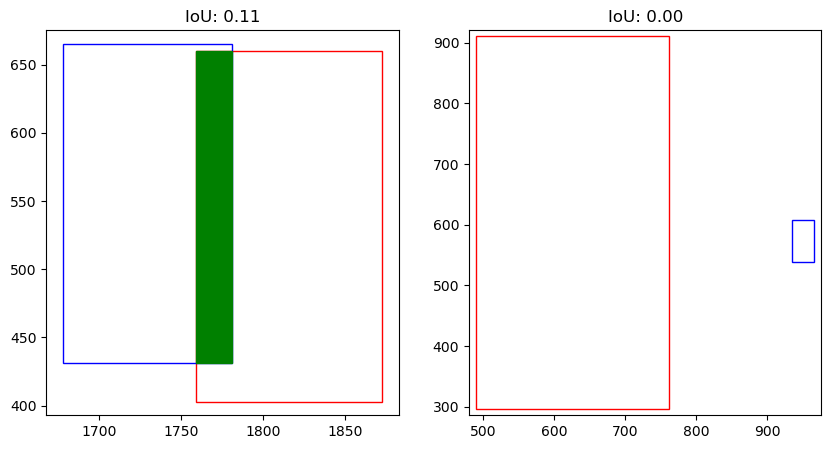

In [69]:
def similarity_matrix_iou(bb_list1: list[BoundingBox], bb_list2: list[BoundingBox]):
    """
    Computes the similarity matrix between two lists of bounding boxes
    :param bb_list1: list of bounding boxes
    :param bb_list2: list of bounding boxes
    :return: similarity matrix
    """
    sim_matrix = np.zeros((len(bb_list1), len(bb_list2)))
    for i, bb1 in enumerate(bb_list1):
        for j, bb2 in enumerate(bb_list2):
            sim_matrix[i, j] = iou(bb1, bb2)
    return sim_matrix


n_frame = 437  # np.random.randint(0, det_df["frame"].max())
print(n_frame)
frame_data = det_df[det_df["frame"] == n_frame]
next_frame_data = det_df[det_df["frame"] == n_frame + 1]
bb_list1 = [
    BoundingBox(*row[["bb_left", "bb_top", "bb_width", "bb_height"]])
    for _, row in frame_data.iterrows()
]
bb_list2 = [
    BoundingBox(*row[["bb_left", "bb_top", "bb_width", "bb_height"]])
    for _, row in next_frame_data.iterrows()
]
sim_matrix = similarity_matrix_iou(bb_list1, bb_list2)
sim_matrix_df = pd.DataFrame(sim_matrix)
sim_matrix_df.index = frame_data.index
sim_matrix_df.columns = next_frame_data.index
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

plot_bounding_boxes(random.choice(bb_list1), random.choice(bb_list2), axs[0])
plot_bounding_boxes(random.choice(bb_list1), random.choice(bb_list2), axs[1])

sim_matrix_df

In [76]:
def iou_tracking(
    det_df,
    img_file_list=IMG_FILE_LIST,
    threshold=0.5,
    csv_file="ADL-Rundle-6/det/restults.csv",
):
    cur_id = 0
    for n_frame, img_file in tqdm(enumerate(img_file_list, start=1)):
        frame_data = det_df[det_df["frame"] == n_frame]
        next_frame_data = det_df[det_df["frame"] == n_frame + 1]
        for i, row1 in enumerate(frame_data.index):
            best_iou = 0
            for j, row2 in enumerate(next_frame_data.index):
                bb1 = BoundingBox(
                    frame_data["bb_left"][row1],
                    frame_data["bb_top"][row1],
                    frame_data["bb_width"][row1],
                    frame_data["bb_height"][row1],
                )
                bb2 = BoundingBox(
                    next_frame_data["bb_left"][row2],
                    next_frame_data["bb_top"][row2],
                    next_frame_data["bb_width"][row2],
                    next_frame_data["bb_height"][row2],
                )
                iou_score = iou(bb1, bb2)

                if det_df.loc[row1, "id"] == -1:
                    det_df.loc[row1, "id"] = cur_id
                    cur_id += 1
                if iou_score >= threshold and iou_score > best_iou:
                    det_df.loc[row2, "id"] = det_df.loc[row1, "id"]

    det_df.to_csv(csv_file, index=False)


det_df = load_det_file(det_file)
iou_tracking(
    det_df,
    csv_file="ADL-Rundle-6/det/restults.csv",
    threshold=0.5,
    img_file_list=IMG_FILE_LIST,
)

525it [00:01, 328.20it/s]


In [72]:
def update_gif(opencv_img, row1, bb1, img_file):
    cv2.rectangle(
        opencv_img,
        (int(bb1.bb_left), int(bb1.bb_top)),
        (
            int(bb1.bb_left + bb1.bb_width),
            int(bb1.bb_top + bb1.bb_height),
        ),
        (0, 0, 255),
        2,
    )
    cv2.putText(
        opencv_img,
        str(det_df.loc[row1, "id"]),
        (int(bb1.bb_left), int(bb1.bb_top)),
        cv2.FONT_HERSHEY_SIMPLEX,
        1,
        (0, 0, 255),
        2,
        cv2.LINE_AA,
    )
    cv2.imwrite(
        os.path.join(BOUNDING_BOX_DIR, img_file),
        opencv_img,
    )

In [78]:
def generate_gif(
    result_csv="ADL-Rundle-6/det/restults.csv",
    img_file_list=IMG_FILE_LIST,
    gif_file="ADL-Rundle-6/bounding_boxes.gif",
    nb_frames=10,
):
    df = pd.read_csv(result_csv, sep=",", header=0)
    img_file_list = img_file_list[:nb_frames]
    for n_frame, img_file in tqdm(enumerate(img_file_list, start=1)):
        res_df = df[df["frame"] == n_frame]
        opencv_img = cv2.imread(os.path.join(IMG_DIR, img_file))
        for row1 in res_df.index:
            bb1 = BoundingBox(
                res_df["bb_left"][row1],
                res_df["bb_top"][row1],
                res_df["bb_width"][row1],
                res_df["bb_height"][row1],
            )
            update_gif(opencv_img, row1, bb1, img_file)
    images = []
    print("Generating gif...")
    bounded_box_files = sorted(os.listdir(BOUNDING_BOX_DIR))[:nb_frames]
    for filename in tqdm(bounded_box_files):
        images.append(imageio.imread(os.path.join(BOUNDING_BOX_DIR, filename)))
    imageio.mimsave(gif_file, images, duration=0.5)
    print("Gif saved at {}".format(gif_file))


generate_gif(
    result_csv="ADL-Rundle-6/det/restults.csv",
    img_file_list=IMG_FILE_LIST,
    gif_file="ADL-Rundle-6/bounding_boxes.gif",
    nb_frames=50,
)

50it [00:06,  7.17it/s]


Generating gif...


  0%|          | 0/50 [00:00<?, ?it/s]/tmp/ipykernel_31674/437424129.py:24: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images.append(imageio.imread(os.path.join(BOUNDING_BOX_DIR, filename)))
100%|██████████| 50/50 [00:00<00:00, 60.72it/s]


Gif saved at ADL-Rundle-6/bounding_boxes.gif


## 3 Detection Association
Associate the detections to tracks in a greedy manner using IoU/ threshold sigma_iou. A track gets the
detection with the highest intersection-over-union to its last known object position (i.e. the previous
detection of the track) assigned.

## 4 Track management
 Each object can be assigned to only one trajectory (ID)
 Create and update lists for matches, unmatched detections and unmatched tracks
 Matches: IoU ≥ sigma_iou -> matched track
 Unmatched tracks -> delete track
 Unmatched detection -> create new tracks